# NLP on Nevada Food Reviews

The goal of this notebook is to do some rudimentary NLP on Reviews on South Carolina

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import spacy
import itertools as it
%matplotlib inline 
import warnings
warnings.simplefilter(action='ignore')

# NLP imports 
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from gensim import models, corpora
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from collections import Counter
from langdetect import detect
from collections import Counter
from textblob import TextBlob
import pyLDAvis.gensim

In [2]:
import matplotlib.patches as mpatches
import pyLDAvis.gensim
pyLDAvis.enable_notebook() # in order for our visual to show up

## Inspecting the Data

In [4]:
data = pd.read_csv("/home/schubert/DSI/capstone_project/data/food_reviews_nv")

In [5]:
data.head(50)

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,name,...,address,city,state,postal_code,latitude,longitude,review_count,is_open,categories,avg_stars
0,--9e1ONYQuAa-CB_Rrw7Tw,KEAHrqN-1DV0gmuNHM6Eww,xP1IYu2eGfxMWV9tjrurIw,5,2011-08-24,As part of a birthday celebration weekend for ...,1,0,0,"""Delmonico Steakhouse""",...,"""3355 Las Vegas Blvd S""",Las Vegas,NV,89109,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
1,--9e1ONYQuAa-CB_Rrw7Tw,6SgvNWJltnZhW7duJgZ42w,oFyOUOeGTRZhFPF9uTqrTQ,5,2016-03-31,This is mine and my fiancé's favorite steakhou...,0,0,0,"""Delmonico Steakhouse""",...,"""3355 Las Vegas Blvd S""",Las Vegas,NV,89109,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
2,--9e1ONYQuAa-CB_Rrw7Tw,iwx6s6yQxc7yjS7NFANZig,2aeNFntqY2QDZLADNo8iQQ,4,2015-06-29,Nice atmosphere and wonderful service. I had t...,0,0,0,"""Delmonico Steakhouse""",...,"""3355 Las Vegas Blvd S""",Las Vegas,NV,89109,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
3,--9e1ONYQuAa-CB_Rrw7Tw,UVUMu_bELdA56Ryfbur-DA,gmPP4YFrgYsYQqPYokMgFA,5,2015-03-16,Every year a group of us (we had 6 this year) ...,1,0,0,"""Delmonico Steakhouse""",...,"""3355 Las Vegas Blvd S""",Las Vegas,NV,89109,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
4,--9e1ONYQuAa-CB_Rrw7Tw,Jjz9W-wBkoBoMcB8ZQs5zQ,9bxdPvAhP6cuipD5s2UnCg,5,2011-12-20,We had early reservations for a party of 9 for...,9,7,8,"""Delmonico Steakhouse""",...,"""3355 Las Vegas Blvd S""",Las Vegas,NV,89109,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
5,--9e1ONYQuAa-CB_Rrw7Tw,UxFpgng8dPMWOj99653k5Q,aVOGlN9fZ-BXcbtj6dbf0g,5,2016-02-10,Truly Fantastic! Best Steak ever. Service was...,0,0,0,"""Delmonico Steakhouse""",...,"""3355 Las Vegas Blvd S""",Las Vegas,NV,89109,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
6,--9e1ONYQuAa-CB_Rrw7Tw,Xp3ppynEvVu1KxDHQ3ae8w,KC8H7qTZVPIEnanw9fG43g,5,2017-02-14,Delmonico Steakhouse is a steakhouse owned by ...,0,0,0,"""Delmonico Steakhouse""",...,"""3355 Las Vegas Blvd S""",Las Vegas,NV,89109,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
7,--9e1ONYQuAa-CB_Rrw7Tw,A5PsAqQYUR03DpV-30wKAA,3gEk6-HQ7DxjY99zypqa8w,4,2013-01-16,Its a fancy steakhouse in Vegas. Sure it was ...,0,0,0,"""Delmonico Steakhouse""",...,"""3355 Las Vegas Blvd S""",Las Vegas,NV,89109,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
8,--9e1ONYQuAa-CB_Rrw7Tw,ICnIa2QhiQrGo2HVATQZDQ,HmN7p502YMJGkBNv5bzi1w,5,2011-09-03,This is what every restaurant aspires to be......,0,0,0,"""Delmonico Steakhouse""",...,"""3355 Las Vegas Blvd S""",Las Vegas,NV,89109,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
9,--9e1ONYQuAa-CB_Rrw7Tw,LEzphAnz0vKE32PUCbjLgQ,3RTesI_MAwct13LWm4rhLw,4,2017-05-28,One of the top steak places I've had in Vegas ...,2,0,1,"""Delmonico Steakhouse""",...,"""3355 Las Vegas Blvd S""",Las Vegas,NV,89109,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0


In [6]:
data["categories"].unique()

array(['Cajun/Creole;Steakhouses;Restaurants',
       'Food;American (New);Nightlife;Bars;Beer;Wine & Spirits;Restaurants',
       'Sports Bars;Pizza;Restaurants;Nightlife;Bars', ...,
       'Hawaiian;Food;Filipino;Restaurants;Food Trucks',
       'Sushi Bars;Japanese;Restaurants;Tapas Bars',
       'Nightlife;Tex-Mex;Mexican;Restaurants;Bars'], dtype=object)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041834 entries, 0 to 1041833
Data columns (total 21 columns):
business_id     1041834 non-null object
review_id       1041834 non-null object
user_id         1041834 non-null object
stars           1041834 non-null int64
date            1041834 non-null object
text            1041834 non-null object
useful          1041833 non-null object
funny           1041833 non-null object
cool            1041833 non-null object
name            1041833 non-null object
neighborhood    874289 non-null object
address         1041833 non-null object
city            1041833 non-null object
state           1041833 non-null object
postal_code     1041524 non-null object
latitude        1041833 non-null float64
longitude       1041832 non-null float64
review_count    1041832 non-null float64
is_open         1041832 non-null float64
categories      1041832 non-null object
avg_stars       1041832 non-null float64
dtypes: float64(5), int64(1), object(15)
mem

## General Cleaning of the Data

Here, We will be dropping all features we will not be using in our analysis

In [10]:
data.columns

Index(['business_id', 'review_id', 'user_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool', 'name', 'neighborhood', 'address', 'city',
       'state', 'postal_code', 'latitude', 'longitude', 'review_count',
       'is_open', 'categories', 'avg_stars'],
      dtype='object')

In [10]:
cols_to_drop = ["neighborhood", "postal_code", "address"]

# dropping neighborhood 
data.drop(cols_to_drop, axis=1, inplace=True)

# # dropping restaurants that are no longer open
# data = data.drop(data[data["is_open"] != 1.0].index)

In [11]:
data.head()

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,name,city,state,latitude,longitude,review_count,is_open,categories,avg_stars
0,--9e1ONYQuAa-CB_Rrw7Tw,KEAHrqN-1DV0gmuNHM6Eww,xP1IYu2eGfxMWV9tjrurIw,5,2011-08-24,As part of a birthday celebration weekend for ...,1,0,0,"""Delmonico Steakhouse""",Las Vegas,NV,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
1,--9e1ONYQuAa-CB_Rrw7Tw,6SgvNWJltnZhW7duJgZ42w,oFyOUOeGTRZhFPF9uTqrTQ,5,2016-03-31,This is mine and my fiancé's favorite steakhou...,0,0,0,"""Delmonico Steakhouse""",Las Vegas,NV,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
2,--9e1ONYQuAa-CB_Rrw7Tw,iwx6s6yQxc7yjS7NFANZig,2aeNFntqY2QDZLADNo8iQQ,4,2015-06-29,Nice atmosphere and wonderful service. I had t...,0,0,0,"""Delmonico Steakhouse""",Las Vegas,NV,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
3,--9e1ONYQuAa-CB_Rrw7Tw,UVUMu_bELdA56Ryfbur-DA,gmPP4YFrgYsYQqPYokMgFA,5,2015-03-16,Every year a group of us (we had 6 this year) ...,1,0,0,"""Delmonico Steakhouse""",Las Vegas,NV,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0
4,--9e1ONYQuAa-CB_Rrw7Tw,Jjz9W-wBkoBoMcB8ZQs5zQ,9bxdPvAhP6cuipD5s2UnCg,5,2011-12-20,We had early reservations for a party of 9 for...,9,7,8,"""Delmonico Steakhouse""",Las Vegas,NV,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0


Now, we need to identify the language the reviews are written in, and then decide whether or not to drop them. 

In [13]:
# checking out the types of languages we are dealing with
lang = []
for text in data["text"]:
    lang.append(detect(text))

print(Counter(lang))

In [14]:
# creating a language identifying feature 
data["lang"] = data["text"].apply(lambda x: detect(x))

In [15]:
# dropping reviews that arent english 
data = data.drop(data[data["lang"] != 'en'].index)

## Feature Creation 

Here, we will be creating additional features we may wish to use for further exploration and analysis

In [17]:
# creating a sentiment score feature 
data["sentiment_score"] = data["text"].apply(lambda x: TextBlob(x).polarity)

In [18]:
# creating a length of review feature 
data["review_length"] = data["text"].apply(len)

In [19]:
# creating a subjectivity score feature
data["subjectivity_score"] = data["text"].apply(lambda x: TextBlob(x).subjectivity)

In [20]:
data.head()

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,name,...,latitude,longitude,review_count,is_open,categories,avg_stars,lang,sentiment_score,review_length,subjectivity_score
0,--9e1ONYQuAa-CB_Rrw7Tw,KEAHrqN-1DV0gmuNHM6Eww,xP1IYu2eGfxMWV9tjrurIw,5,2011-08-24,As part of a birthday celebration weekend for ...,1,0,0,"""Delmonico Steakhouse""",...,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0,en,0.405723,1674,0.673525
1,--9e1ONYQuAa-CB_Rrw7Tw,6SgvNWJltnZhW7duJgZ42w,oFyOUOeGTRZhFPF9uTqrTQ,5,2016-03-31,This is mine and my fiancé's favorite steakhou...,0,0,0,"""Delmonico Steakhouse""",...,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0,en,0.284375,341,0.684226
2,--9e1ONYQuAa-CB_Rrw7Tw,iwx6s6yQxc7yjS7NFANZig,2aeNFntqY2QDZLADNo8iQQ,4,2015-06-29,Nice atmosphere and wonderful service. I had t...,0,0,0,"""Delmonico Steakhouse""",...,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0,en,0.383492,417,0.542698
3,--9e1ONYQuAa-CB_Rrw7Tw,UVUMu_bELdA56Ryfbur-DA,gmPP4YFrgYsYQqPYokMgFA,5,2015-03-16,Every year a group of us (we had 6 this year) ...,1,0,0,"""Delmonico Steakhouse""",...,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0,en,0.310536,493,0.625476
4,--9e1ONYQuAa-CB_Rrw7Tw,Jjz9W-wBkoBoMcB8ZQs5zQ,9bxdPvAhP6cuipD5s2UnCg,5,2011-12-20,We had early reservations for a party of 9 for...,9,7,8,"""Delmonico Steakhouse""",...,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0,en,0.272811,1997,0.688721


In [21]:
data.columns

Index(['business_id', 'review_id', 'user_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool', 'name', 'city', 'state', 'latitude',
       'longitude', 'review_count', 'is_open', 'categories', 'avg_stars',
       'lang', 'sentiment_score', 'review_length', 'subjectivity_score'],
      dtype='object')

## General EDA Through Visualizations 

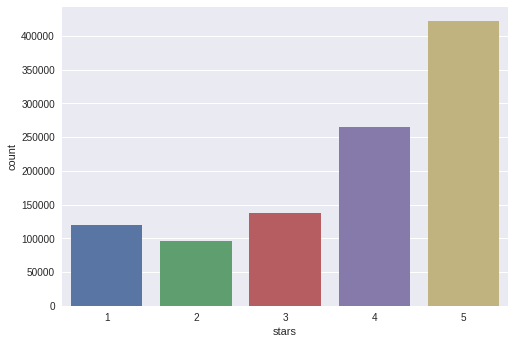

In [22]:
# distribution of star raitings in our dataset 
sns.set(style="darkgrid")
ax = sns.countplot(x="stars", data=data)
plt.savefig('star_dist_bars.png');

**Observations**: 

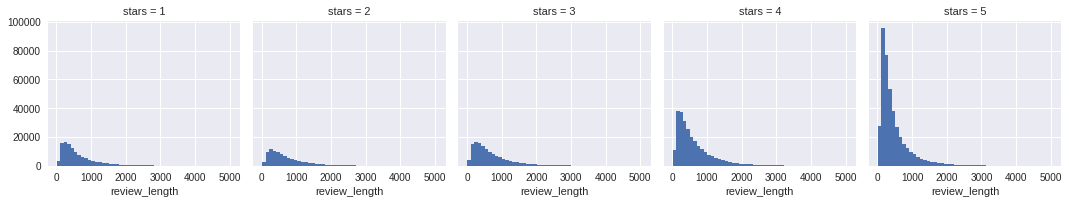

In [23]:
# seeign how review length changed by star raiting 
g = sns.FacetGrid(data=data, col='stars')
g.map(plt.hist, 'review_length', bins=50);
plt.savefig('text_length.png')

**Observations**: 

In [24]:
mask = ["useful", "funny", "cool", "review_length", "sentiment_score", "subjectivity_score", "stars"]

In [25]:
data_feat = data[mask]

In [26]:
stars = data_feat.groupby('stars').mean()
star = stars.corr()
star

,review_length,sentiment_score,subjectivity_score
review_length,1.000000,-0.674871,-0.875956
sentiment_score,-0.674871,1.000000,0.939763
subjectivity_score,-0.875956,0.939763,1.000000


/home/schubert/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/schubert/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


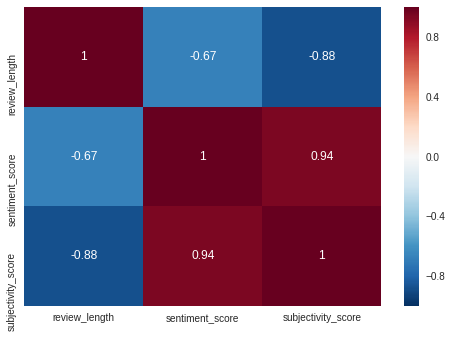

In [27]:
sns.heatmap(data=stars.corr(), annot=True);

/home/schubert/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/schubert/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


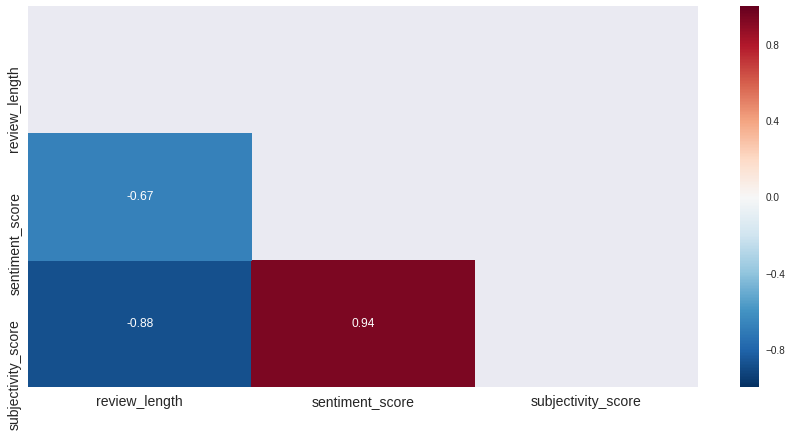

In [28]:
# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(15,7))

# Generates a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(star, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generating our correlation heatmap
ax = sns.heatmap(star, mask=mask, ax=ax, annot = True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show();
plt.savefig('feature_corr.png')

**Observations**:

Things to do
- How sentiment affects stars; that whole criss cross match (stars)
- 

In [29]:
data.head()

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,name,...,latitude,longitude,review_count,is_open,categories,avg_stars,lang,sentiment_score,review_length,subjectivity_score
0,--9e1ONYQuAa-CB_Rrw7Tw,KEAHrqN-1DV0gmuNHM6Eww,xP1IYu2eGfxMWV9tjrurIw,5,2011-08-24,As part of a birthday celebration weekend for ...,1,0,0,"""Delmonico Steakhouse""",...,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0,en,0.405723,1674,0.673525
1,--9e1ONYQuAa-CB_Rrw7Tw,6SgvNWJltnZhW7duJgZ42w,oFyOUOeGTRZhFPF9uTqrTQ,5,2016-03-31,This is mine and my fiancé's favorite steakhou...,0,0,0,"""Delmonico Steakhouse""",...,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0,en,0.284375,341,0.684226
2,--9e1ONYQuAa-CB_Rrw7Tw,iwx6s6yQxc7yjS7NFANZig,2aeNFntqY2QDZLADNo8iQQ,4,2015-06-29,Nice atmosphere and wonderful service. I had t...,0,0,0,"""Delmonico Steakhouse""",...,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0,en,0.383492,417,0.542698
3,--9e1ONYQuAa-CB_Rrw7Tw,UVUMu_bELdA56Ryfbur-DA,gmPP4YFrgYsYQqPYokMgFA,5,2015-03-16,Every year a group of us (we had 6 this year) ...,1,0,0,"""Delmonico Steakhouse""",...,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0,en,0.310536,493,0.625476
4,--9e1ONYQuAa-CB_Rrw7Tw,Jjz9W-wBkoBoMcB8ZQs5zQ,9bxdPvAhP6cuipD5s2UnCg,5,2011-12-20,We had early reservations for a party of 9 for...,9,7,8,"""Delmonico Steakhouse""",...,36.123183,-115.16919,1451.0,1.0,Cajun/Creole;Steakhouses;Restaurants,4.0,en,0.272811,1997,0.688721


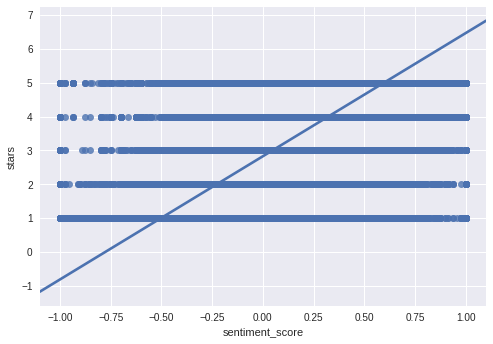

In [30]:
# plotting sentiment score vs stars 
ax = sns.regplot(x="sentiment_score", y="stars", data=data)

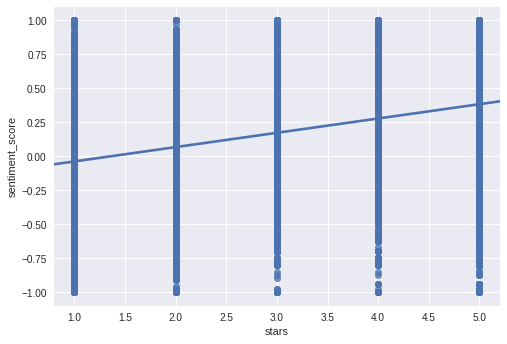

In [31]:
ax = sns.regplot(x="stars", y="sentiment_score", data=data)

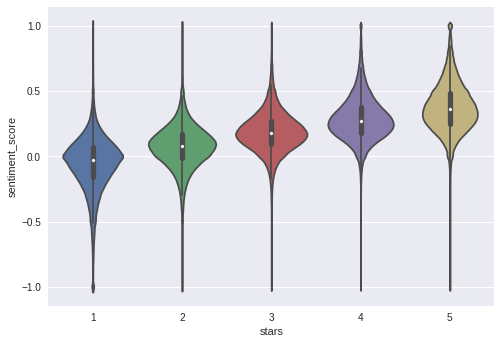

In [32]:
ax = sns.violinplot(x="stars", y="sentiment_score", data=data)

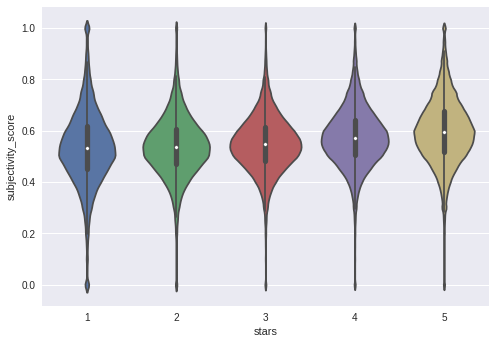

In [33]:
ax = sns.violinplot(x="stars", y="subjectivity_score", data=data)

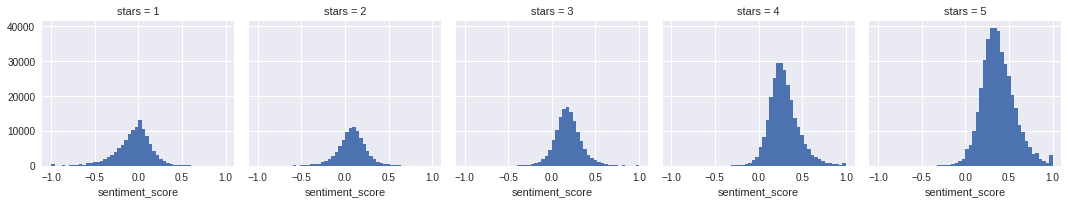

In [34]:
# still checking sentiment score and star raiting
g = sns.FacetGrid(data=data, col='stars')
g.map(plt.hist, 'sentiment_score', bins=50)
plt.savefig('sentiment_stars.png');

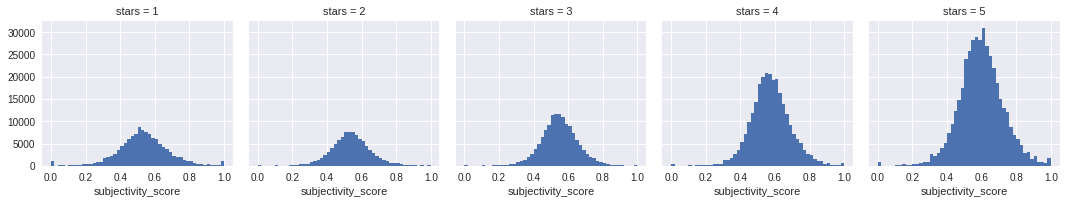

In [35]:
g = sns.FacetGrid(data=data, col='stars')
g.map(plt.hist, 'subjectivity_score', bins=50)
plt.savefig('subjectivity_stars.png')

Let's create a new feature where its 4 stars and above vs under four stars. My reasoning is the following: 
- 4 and above is pretty positive. Indicates a rather good dining experience with little to no qualms 
- 3 and below means that there was something "less than ideal" about the dining experience. It is from this category that we will be able to pull the key patron "pain points" via topic modeling and other methods. 
- This being said, the best way to do this in my opinion is to one hot encode `stars`. That way I still retain that level of filtering should I need it later down the line

In [36]:
# dummies of stars 
dummies = pd.get_dummies(data['stars'])
data = pd.concat([data, dummies], axis=1) 

In [37]:
# creating categorical feature of above or below 4 stars 
data["above_4"] = data["stars"].map(lambda x: 1 if x>3 else 0)

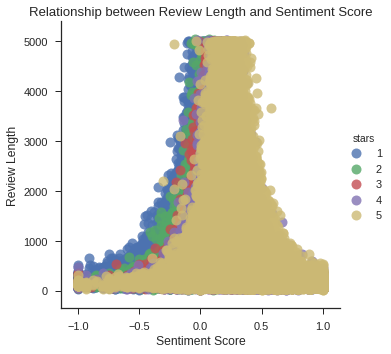

In [38]:
# Setting style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot('sentiment_score',
           'review_length', 
           data=data,
           fit_reg=False,
           hue="stars",
           scatter_kws={"marker": "D", 
                        "s": 100}) 

plt.title('Relationship between Review Length and Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Review Length')
plt.savefig('text_lenght_sentiment.png');

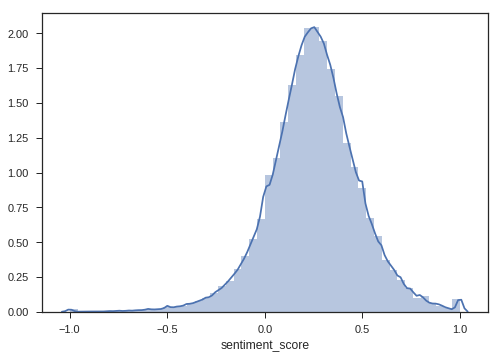

In [39]:
# plotting the distribution of sentiment 
sns.distplot(data["sentiment_score"])
plt.savefig('sent_gen.png');

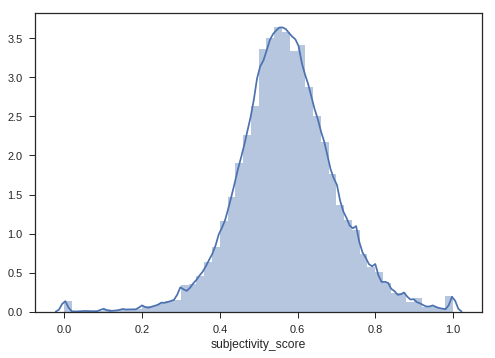

In [40]:
# plotting the distribution of subjectivity 
sns.distplot(data["subjectivity_score"])
plt.savefig('subj_gen.png');

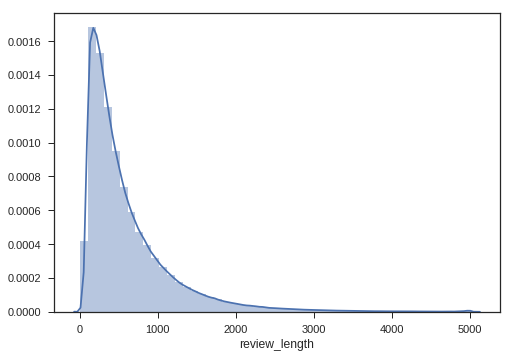

In [41]:
sns.distplot(data["review_length"])
plt.savefig('review_lenght_gen.png');

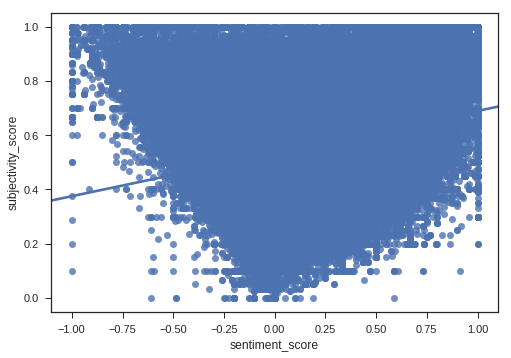

In [42]:
ax = sns.regplot(x="sentiment_score", y="subjectivity_score", data=data)

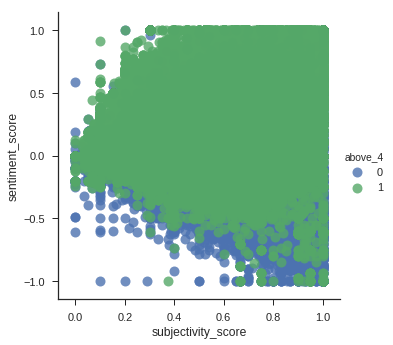

In [43]:
# Setting style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot('subjectivity_score',
           'sentiment_score', 
           data=data,
           fit_reg=False,
           hue="above_4",
           scatter_kws={"marker": "D", 
                        "s": 100,
                       #"alpha": 0.5
                       })
plt.savefig('sent_subj.png'); 

## Creating Maps 

- When we get chance, try this out: http://folium.readthedocs.io/en/latest/quickstart.html

In [69]:
ratings = data[['business_id', 'user_id', 'name', 'sentiment_score']]

In [70]:
ratings.head()

,business_id,user_id,name,sentiment_score
0,--9e1ONYQuAa-CB_Rrw7Tw,xP1IYu2eGfxMWV9tjrurIw,"""Delmonico Steakhouse""",0.405723
1,--9e1ONYQuAa-CB_Rrw7Tw,oFyOUOeGTRZhFPF9uTqrTQ,"""Delmonico Steakhouse""",0.284375
2,--9e1ONYQuAa-CB_Rrw7Tw,2aeNFntqY2QDZLADNo8iQQ,"""Delmonico Steakhouse""",0.383492
3,--9e1ONYQuAa-CB_Rrw7Tw,gmPP4YFrgYsYQqPYokMgFA,"""Delmonico Steakhouse""",0.310536
4,--9e1ONYQuAa-CB_Rrw7Tw,9bxdPvAhP6cuipD5s2UnCg,"""Delmonico Steakhouse""",0.272811


In [71]:
# ratings.to_csv('sent_rec_data_nv', encoding='utf-8', index=False)

## Creating Pos/Neg and Subjective/NotSubjective categorical features

In [44]:
data["pos_sentiment"] = data["sentiment_score"].map(lambda x: 1 if x>=0 else 0)

In [45]:
data["is_subjective"] = data["subjectivity_score"].map(lambda x: 1 if x>=0.5 else 0)

In [46]:
data.head()

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,name,...,review_length,subjectivity_score,1,2,3,4,5,above_4,pos_sentiment,is_subjective
0,--9e1ONYQuAa-CB_Rrw7Tw,KEAHrqN-1DV0gmuNHM6Eww,xP1IYu2eGfxMWV9tjrurIw,5,2011-08-24,As part of a birthday celebration weekend for ...,1,0,0,"""Delmonico Steakhouse""",...,1674,0.673525,0,0,0,0,1,1,1,1
1,--9e1ONYQuAa-CB_Rrw7Tw,6SgvNWJltnZhW7duJgZ42w,oFyOUOeGTRZhFPF9uTqrTQ,5,2016-03-31,This is mine and my fiancé's favorite steakhou...,0,0,0,"""Delmonico Steakhouse""",...,341,0.684226,0,0,0,0,1,1,1,1
2,--9e1ONYQuAa-CB_Rrw7Tw,iwx6s6yQxc7yjS7NFANZig,2aeNFntqY2QDZLADNo8iQQ,4,2015-06-29,Nice atmosphere and wonderful service. I had t...,0,0,0,"""Delmonico Steakhouse""",...,417,0.542698,0,0,0,1,0,1,1,1
3,--9e1ONYQuAa-CB_Rrw7Tw,UVUMu_bELdA56Ryfbur-DA,gmPP4YFrgYsYQqPYokMgFA,5,2015-03-16,Every year a group of us (we had 6 this year) ...,1,0,0,"""Delmonico Steakhouse""",...,493,0.625476,0,0,0,0,1,1,1,1
4,--9e1ONYQuAa-CB_Rrw7Tw,Jjz9W-wBkoBoMcB8ZQs5zQ,9bxdPvAhP6cuipD5s2UnCg,5,2011-12-20,We had early reservations for a party of 9 for...,9,7,8,"""Delmonico Steakhouse""",...,1997,0.688721,0,0,0,0,1,1,1,1


In [47]:
data.columns

Index([       'business_id',          'review_id',            'user_id',
                    'stars',               'date',               'text',
                   'useful',              'funny',               'cool',
                     'name',               'city',              'state',
                 'latitude',          'longitude',       'review_count',
                  'is_open',         'categories',          'avg_stars',
                     'lang',    'sentiment_score',      'review_length',
       'subjectivity_score',                    1,                    2,
                          3,                    4,                    5,
                  'above_4',      'pos_sentiment',      'is_subjective'],
      dtype='object')

## NLP Analysis: 1st pass 

The goal of this section is to explore and better understand what constitutes the different types of reviews.

**Step 1**: Subsection the data into different categories before tokenization and analysis 

In [48]:
# df of reviews with more than 4 stars 
mask = data["above_4"] != 0
above_4_stars = data[mask]

In [49]:
# df of reviews with less than 4 stars 
mask = data["above_4"] != 1
below_4_stars = data[mask]

In [50]:
# df of reviews with positive sentiment in reviews
mask = data["pos_sentiment"] !=0
pos_sentiment = data[mask]

In [51]:
# df of reviews with negative sentiment in reviews
mask = data["pos_sentiment"] !=1
neg_sentiment = data[mask]

In [52]:
# df ofsubjective reviews
mask = data["is_subjective"] !=0
is_subjective = data[mask]

In [53]:
# df of reviews that aren't subjective
mask = data["is_subjective"] !=1
not_subjective = data[mask]

In [54]:
# df of reviews that scored restaurant 1 star
mask = data[1] !=0
one_star = data[mask]

In [55]:
# df of reviews that scored restaurant 5 stars
mask = data[5] !=0
five_stars = data[mask]

**Step 2**: isolate review text from the DataFrames created above 

In [56]:
all_review_text = data["text"]
above_4_stars_text = above_4_stars["text"]
below_4_stars_text = below_4_stars["text"]
pos_sentiment_text = pos_sentiment["text"]
neg_sentiment_text = neg_sentiment["text"]
is_subjective_text = is_subjective["text"]
not_subjective_text = not_subjective["text"]
one_star_text = one_star["text"]
five_stars_text = five_stars["text"]

In [57]:
all_review_text[1]

"This is mine and my fiancé's favorite steakhouse here in Las Vegas! We often stop in and see our favorite server, Michael Jackson, who simply completes the fine dining experience for us. He is always so pleasant and knowledgable about the menu and suggests amazing dishes each time! I have never been disappointed here and will be back soon!"

In [59]:
# one_star_text[40]

**Step 3**: Process and clean the review text
Basically were going to clean and tokenize the text so that we can do further NLP analysis on it. 

In [60]:
def process(input_text):
    '''
    Processor function for tokenizing,
    removing stop words, and stemming
    '''
    # Creates a regular expression tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    
    # Creates a Snowball stemmer
    stemmer = SnowballStemmer('english')
    stop_words = stopwords.words('english')
    
    # Tokenizes the input string
    tokens = tokenizer.tokenize(input_text.lower())
    tokens = [x for x in tokens if not x in stop_words]
    
    # Performs stemming on the tokenized words
    tokens_stemmed = [stemmer.stem(x) for x in tokens]
    return tokens_stemmed

In [61]:
# creating tokens based on review text
tokens_all = all_review_text.apply(process)
tokens_above_4 = above_4_stars_text.apply(process)
tokens_below_4 = below_4_stars_text.apply(process)
tokens_pos_sent = pos_sentiment_text.apply(process)
tokens_neg_sent = neg_sentiment_text.apply(process)
tokens_is_subjective = is_subjective_text.apply(process)
tokens_not_sibjective = not_subjective_text.apply(process)
tokens_one_star = one_star_text.apply(process)
tokens_5_stars = five_stars_text.apply(process)

In [62]:
tokens_5_stars

0          [part, birthday, celebr, weekend, two, cousin,...
1          [mine, fiancé, favorit, steakhous, las, vega, ...
3          [everi, year, group, us, 6, year, goe, vega, t...
4          [earli, reserv, parti, 9, 40th, birthday, seat...
5          [truli, fantast, best, steak, ever, servic, aw...
6          [delmonico, steakhous, steakhous, own, emeril,...
8          [everi, restaur, aspir, perfect, everyth, perf...
10         [look, fanci, steakhous, vega, delmonico, go, ...
11         [place, superb, custom, servic, food, area, hi...
12         [decid, give, delmonico, tri, receiv, special,...
15         [absolut, impress, restaur, entir, dine, exper...
20         [walk, sunday, even, reserv, portion, size, ex...
21         [long, time, sinc, delmonico, use, big, fan, e...
26         [california, foie, gras, ban, foie, gras, miss...
31         [ben, steakhous, las, vega, well, usual, stay,...
32         [phenomen, came, back, celebr, birthday, every...
37         [wow, first, 

In [63]:
tokens_one_star

34         [suppos, special, dinner, 10, husband, 50th, b...
53         [went, alon, eat, experi, expect, free, bread,...
65         [ces, trade, show, look, lunch, show, 2, 03, h...
78         [go, unless, love, salt, took, husband, delmon...
109        [wow, believ, place, get, 4, star, bam, poof, ...
110        [like, steak, ask, medium, rare, wel, done, co...
118        [visit, place, friend, vega, wed, say, enough,...
149        [famili, busi, associ, visit, delmonico, past,...
180        [first, love, emeril, think, food, old, school...
213        [read, bad, review, realiz, one, happen, first...
215        [went, anniversari, know, emerald, restaur, ex...
239        [disappoint, delmonico, steakhous, order, stea...
308        [tradit, new, orlean, gumbo, tasteless, lobste...
317        [dinner, reserv, 6, 00, march, 4th, excit, eat...
407        [dine, delmonico, yesterday, lunch, total, fou...
418        [perfect, end, memori, day, weekend, vega, gre...
428        [fact, abl, c

In [64]:
analyser = SentimentIntensityAnalyzer()

In [65]:
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

In [67]:
# print_sentiment_scores(one_star["text"][100])

In [72]:
# Creating dictonaries based on the sentence tokens
dict_tokens0 = corpora.Dictionary(tokens_all)
dict_tokens1 = corpora.Dictionary(tokens_above_4)
dict_tokens2 = corpora.Dictionary(tokens_below_4)
dict_tokens3 = corpora.Dictionary(tokens_pos_sent)
dict_tokens4 = corpora.Dictionary(tokens_neg_sent)
dict_tokens5 = corpora.Dictionary(tokens_is_subjective)
dict_tokens6 = corpora.Dictionary(tokens_not_sibjective)
dict_tokens7 = corpora.Dictionary(tokens_one_star)
dict_tokens8 = corpora.Dictionary(tokens_5_stars)

In [ ]:
# Creating a document-term matrix for each dictonary 
doc_term_mat0 = [dict_tokens0.doc2bow(token) for token in tokens_all]
doc_term_mat1 = [dict_tokens1.doc2bow(token) for token in tokens_above_4]
doc_term_mat2 = [dict_tokens2.doc2bow(token) for token in tokens_below_4]
doc_term_mat3 = [dict_tokens3.doc2bow(token) for token in tokens_pos_sent]
doc_term_mat4 = [dict_tokens4.doc2bow(token) for token in tokens_neg_sent]
doc_term_mat5 = [dict_tokens5.doc2bow(token) for token in tokens_is_subjective]
doc_term_mat6 = [dict_tokens6.doc2bow(token) for token in tokens_not_sibjective]
doc_term_mat7 = [dict_tokens7.doc2bow(token) for token in tokens_one_star]
doc_term_mat8 = [dict_tokens8.doc2bow(token) for token in tokens_5_stars]

## Modeling and Analysis: Latent Derichlet Allocation 

In [ ]:
num_topics = 5

In [ ]:
num_words = 5

**All Reviews**

In [ ]:
# Generating the LDA model
ldamodel0 = models.ldamodel.LdaModel(doc_term_mat0,
                                    num_topics=num_topics,
                                    id2word=dict_tokens0,
                                    passes=25, alpha=1)

In [ ]:
ldamodel0.print_topics(num_topics=num_topics, num_words=num_words)

In [ ]:
num_words = 5
print('\nTop ' + str(num_words) + ' contributing words to each topic:')
for topic_id, tokens in ldamodel0.print_topics(num_topics=num_topics, num_words=num_words):


    print('\nTopic', topic_id)
    print('\nTokens', tokens)
    
# # Print the contributing words along with their relative contributions
# list_of_strings = item[1].split(' + ')
# for text in list_of_strings:
#     weight = text.split('*')[0]
#     word = text.split('*')[1]
#     print(word, '==>', str(round(float(weight) * 100, 2)) + '%')

**Reviews above 4 stars**

In [ ]:
# Generating the LDA model
ldamodel1 = models.ldamodel.LdaModel(doc_term_mat1,
                                    num_topics=num_topics,
                                    id2word=dict_tokens1,
                                    passes=25, alpha=1)

In [ ]:
ldamodel1.print_topics(num_topics=num_topics, num_words=num_words)

In [ ]:
num_words = 5
print('\nTop ' + str(num_words) + ' contributing words to each topic:')
for topic_id, tokens in ldamodel1.print_topics(num_topics=num_topics, num_words=num_words):


    print('\nTopic', topic_id)
    print('\nTokens', tokens)

**Reviews Below 4 stars**

In [ ]:
# Generating the LDA model
ldamodel2 = models.ldamodel.LdaModel(doc_term_mat2,
                                    num_topics=num_topics,
                                    id2word=dict_tokens2,
                                    passes=25, alpha=1)

In [ ]:
ldamodel2.print_topics(num_topics=num_topics, num_words=num_words)

In [ ]:
num_words = 5
print('\nTop ' + str(num_words) + ' contributing words to each topic:')
for topic_id, tokens in ldamodel2.print_topics(num_topics=num_topics, num_words=num_words):


    print('\nTopic', topic_id)
    print('\nTokens', tokens)
    

**Reviews with Positive Sentiment**

In [ ]:
# Generating the LDA model
ldamodel3 = models.ldamodel.LdaModel(doc_term_mat3,
                                    num_topics=num_topics,
                                    id2word=dict_tokens3,
                                    passes=25, alpha=1)

In [ ]:
ldamodel3.print_topics(num_topics=num_topics, num_words=num_words)

In [ ]:
num_words = 5
print('\nTop ' + str(num_words) + ' contributing words to each topic:')
for topic_id, tokens in ldamodel3.print_topics(num_topics=num_topics, num_words=num_words):


    print('\nTopic', topic_id)
    print('\nTokens', tokens)
    

**Reviews with negative sentiment**

In [ ]:
# Generating the LDA model
ldamodel4 = models.ldamodel.LdaModel(doc_term_mat4,
                                    num_topics=num_topics,
                                    id2word=dict_tokens4,
                                    passes=25, alpha=1)

In [ ]:
ldamodel4.print_topics(num_topics=num_topics, num_words=num_words)

In [ ]:
num_words = 5
print('\nTop ' + str(num_words) + ' contributing words to each topic:')
for topic_id, tokens in ldamodel4.print_topics(num_topics=num_topics, num_words=num_words):


    print('\nTopic', topic_id)
    print('\nTokens', tokens)
    

**Subjective Reviews**

In [ ]:
# Generating the LDA model
ldamodel5 = models.ldamodel.LdaModel(doc_term_mat5,
                                    num_topics=num_topics,
                                    id2word=dict_tokens5,
                                    passes=25, alpha=1)

In [ ]:
ldamodel5.print_topics(num_topics=num_topics, num_words=num_words)

In [ ]:
num_words = 5
print('\nTop ' + str(num_words) + ' contributing words to each topic:')
for topic_id, tokens in ldamodel5.print_topics(num_topics=num_topics, num_words=num_words):


    print('\nTopic', topic_id)
    print('\nTokens', tokens)
    

**Objective Reviews

In [ ]:
# Generating the LDA model
ldamodel6 = models.ldamodel.LdaModel(doc_term_mat6,
                                    num_topics=num_topics,
                                    id2word=dict_tokens6,
                                    passes=25, alpha=1)

In [ ]:
ldamodel6.print_topics(num_topics=num_topics, num_words=num_words)

In [ ]:
num_words = 5
print('\nTop ' + str(num_words) + ' contributing words to each topic:')
for topic_id, tokens in ldamodel6.print_topics(num_topics=num_topics, num_words=num_words):


    print('\nTopic', topic_id)
    print('\nTokens', tokens)
    

**One Star Reviews**

In [ ]:
# Generating the LDA model
ldamodel7 = models.ldamodel.LdaModel(doc_term_mat7,
                                    num_topics=num_topics,
                                    id2word=dict_tokens7,
                                    passes=25, alpha=1)

In [ ]:
ldamodel7.print_topics(num_topics=num_topics, num_words=num_words)

In [ ]:
num_words = 5
print('\nTop ' + str(num_words) + ' contributing words to each topic:')
for topic_id, tokens in ldamodel7.print_topics(num_topics=num_topics, num_words=num_words):


    print('\nTopic', topic_id)
    print('\nTokens', tokens)
    

**5 Star Reviews** 

In [ ]:
# Generating the LDA model
ldamodel8 = models.ldamodel.LdaModel(doc_term_mat8,
                                    num_topics=num_topics,
                                    id2word=dict_tokens8,
                                    passes=25, alpha=1)

In [ ]:
ldamodel8.print_topics(num_topics=num_topics, num_words=num_words)

In [ ]:
num_words = 5
print('\nTop ' + str(num_words) + ' contributing words to each topic:')
for topic_id, tokens in ldamodel8.print_topics(num_topics=num_topics, num_words=num_words):


    print('\nTopic', topic_id)
    print('\nTokens', tokens)
    

Checking out TFIDF 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(stop_words='english')
tvec.fit(one_star_text)

In [ ]:
pyLDAvis.gensim.prepare(ldamodel0, doc_term_mat0, dict_tokens0)

In [ ]:
pyLDAvis.gensim.prepare(ldamodel1, doc_term_mat1, dict_tokens1)

In [ ]:
pyLDAvis.gensim.prepare(ldamodel2, doc_term_mat2, dict_tokens2)

In [ ]:
pyLDAvis.gensim.prepare(ldamodel3, doc_term_mat3, dict_tokens3)

In [ ]:
# ldamodel.print_topics(num_topics=num_topics, num_words=num_words)

In [ ]:
# num_words = 5
# print('\nTop ' + str(num_words) + ' contributing words to each topic:')
# for topic_id, tokens in ldamodel.print_topics(num_topics=num_topics, num_words=num_words):


#     print('\nTopic', topic_id)
#     print('\nTokens', tokens)
    
# # Print the contributing words along with their relative contributions
# list_of_strings = item[1].split(' + ')
# for text in list_of_strings:
#     weight = text.split('*')[0]
#     word = text.split('*')[1]
#     print(word, '==>', str(round(float(weight) * 100, 2)) + '%')

In [ ]:
# vader = SentimentIntensityAnalyzer()
# print(vader.polarity_scores(review_text[100]))
# # turn it to dataframe and then concatenate ?

In [ ]:
blob = TextBlob(data["text"][0])

In [ ]:
blob.tags

In [ ]:
blob.noun_phrases

In [ ]:
# seperate out good and bad
# 3 filter out negative ordinals 

# look into taking average of text blobs 

for sentence in blob.sentences:
    print(sentence.sentiment.polarity)

## Stating with the Basics

In [ ]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(data["text"], y, test_size=0.30, random_state=42)

#### Bag of Words Model
Here, we will create a bag of words model to get a better sense of our data. What words are hot, whats not ext... 

In [ ]:
X_train.head

In [ ]:
# instantiaing CountVectorizer 
cvec = CountVectorizer(stop_words='english') # should I be setting max_df

# making our corpus 
corpus = data["text"]

In [ ]:
cvec.fit(corpus)

# tansforming corpus 
new_corpus = cvec.transform(corpus)

In [ ]:
new_corpus

In [ ]:
new_corpus.todense()

In [ ]:
cvec.get_feature_names()

In [ ]:
# X_train = pd.DataFrame(cvec.transform(data["text"]).todense(),
#                        columns=cvec.get_feature_names())

In [ ]:
word_counts = X_train.sum(axis=0)
word_counts.sort_values(ascending = False).head(20)

In [ ]:
y_train = data["stars"]

In [ ]:
# closer look at the most common words

# Recommender System Based on Sentiment Score 

In [ ]:
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [ ]:
data.head()

In [ ]:
data.columns

In [ ]:
# pure rec dataframe 
rec_data = data[["business_id", "name", "user_id", "sentiment_score"]]

In [ ]:
rec_data.head()

In [ ]:
rec_data.to_csv("sent_rec_data", encoding='utf-8', index=False)

In [ ]:
# need an index of all users, and single column for every restaurant 
pivot = pd.pivot_table(rec_data, index='user_id', columns='name', values='sentiment_score')

In [ ]:
pivot.head()

In [ ]:
# item based colaborative filter, so we transpose, and create a sparse dataframe 
sparse_pivot = sparse.csr_matrix(pivot.T.fillna(0))

In [ ]:
# print(sparse_pivot)

### Calculating Cosine Similarity 

In [ ]:
sparse_pivot.shape

In [ ]:
distances = pairwise_distances(sparse_pivot, metric='cosine')

In [ ]:
distances.shape

In [ ]:
distance_df = pd.DataFrame(distances, index=pivot.columns, columns=pivot.columns)
distance_df.head()

In [ ]:
search = '"Angelos of Fort Mill"'
for resto in rec_data.loc[rec_data['name'].str.contains(search), 'name'].values:
    print(resto)
    print('Average Sentiment', pivot[resto].mean())
    print('Count of Sentiment Scores', pivot[resto].count())
    print('Similar Restaurants')
    print(distance_df[resto].sort_values()[1:11])
    print('')
    print('')